In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [27]:
df = pd.read_csv(r'D:\Detection-of-Diabetic-Retinopathy-using-CNN-main\archive (1)\train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

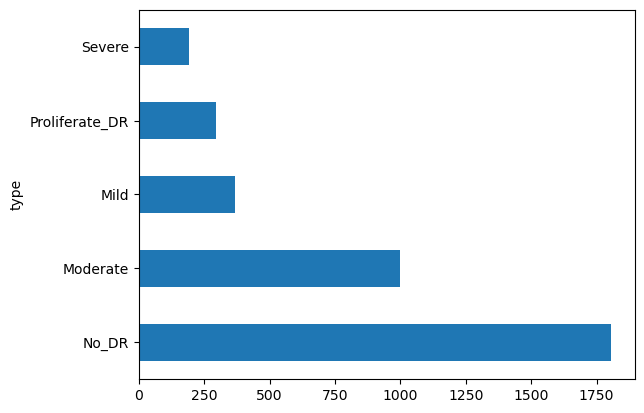

In [28]:
df['type'].value_counts().plot(kind='barh')

<Axes: xlabel='binary_type'>

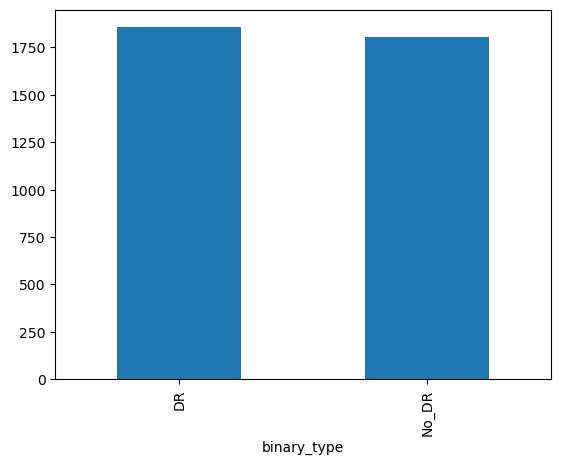

In [29]:
df['binary_type'].value_counts().plot(kind='bar')

In [30]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [31]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [45]:
# Copy images to respective working directory
# src_dir = r'gaussian_filtered_images'
import os


src_dir = r"D:\Detection-of-Diabetic-Retinopathy-using-CNN-main\archive (1)\gaussian_filtered_images\gaussian_filtered_images"

# subdirs = [subdir for subdir in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, subdir))]

# print("Subdirectories within the source directory:")
# for subdir in subdirs:
#     print(os.path.join(src_dir, subdir))

# subdirs = ['NO_DR', 'Moderate']

# for subdir in subdirs:
#     subdir_path = os.path.join(src_dir, subdir)
#     if os.path.exists(subdir_path):
#         print("Subdirectory '{}' found under '{}'".format(subdir, src_dir))
#     else:
#         print("Subdirectory '{}' not found under '{}'".format(subdir, src_dir))

for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [46]:
# Setting up ImageDataGenerator for train/val/test

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [47]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

Epoch 1/30
81/81 [==============================] - 36s 428ms/step - loss: 0.3238 - acc: 0.9052 - val_loss: 0.8083 - val_acc: 0.5073
Epoch 2/30
81/81 [==============================] - 26s 318ms/step - loss: 0.2026 - acc: 0.9333 - val_loss: 0.6580 - val_acc: 0.8036
Epoch 3/30
81/81 [==============================] - 26s 326ms/step - loss: 0.1547 - acc: 0.9450 - val_loss: 0.5882 - val_acc: 0.5709
Epoch 4/30
81/81 [==============================] - 26s 316ms/step - loss: 0.0840 - acc: 0.9637 - val_loss: 0.5265 - val_acc: 0.7545
Epoch 5/30
81/81 [==============================] - 26s 320ms/step - loss: 0.0485 - acc: 0.9797 - val_loss: 0.7595 - val_acc: 0.5745
Epoch 6/30
81/81 [==============================] - 26s 323ms/step - loss: 0.0635 - acc: 0.9738 - val_loss: 1.1085 - val_acc: 0.7564
Epoch 7/30
81/81 [==============================] - 26s 321ms/step - loss: 0.0324 - acc: 0.9867 - val_loss: 0.4393 - val_acc: 0.8691
Epoch 8/30
81/81 [==============================] - 26s 325ms/step - 

In [48]:
model.save('64x3-CNN.model')

INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


In [58]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)


C:\Users\Dell\AppData\Local\Temp\ipykernel_8544\4010420734.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 2s 126ms/step - loss: 5.4161 - acc: 0.7145
Accuracy:  0.7145454287528992


# ****Diabet Retinopathy Detection Section****

In [64]:
model.save('my_model.h5')

1/1 [==============================] - 0s 157ms/step
DR


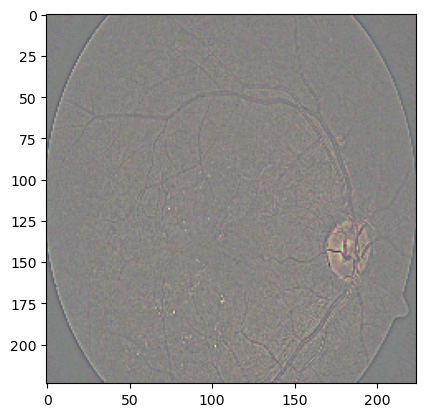

In [73]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_class(path):
    img = cv2.imread(path)
    if img is None:
        raise ValueError("Failed to load image at path: " + path)

    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (224, 224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict = new_model.predict(np.array([image]))
    per = np.argmax(predict, axis=1)
    if per == 1:
        print('No DR')
    else:
        print('DR')

# Call the function with the image path
predict_class(r'test\DR\0d0a21fd354f.png')


1/1 [==============================] - 0s 135ms/step
No DR


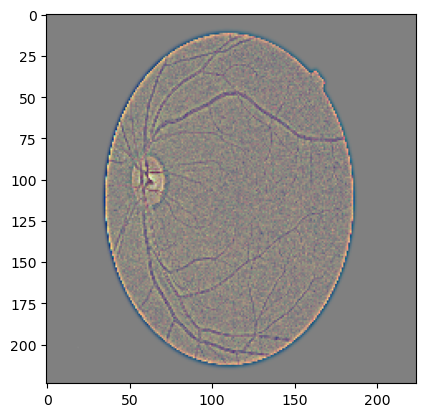

In [76]:
predict_class(r'test\No_DR\0a74c92e287c.png')